# Preparing the data and useful functions

## Import the usual suspects

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
import io
import smtplib
import string
import spacy
import pickle as pkl

PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32

## Function to tell us when our jobs are done

In [2]:
#created this function to notify me when a job is done or almost done
def sendmail(job='',percentage=100):
    mail='yk1859@nyu.edu'
    server = smtplib.SMTP('smtp.gmail.com:587')
    server.ehlo()
    server.starttls()
    server.login("notificationmta@gmail.com", "PyProject1859")
    #Send the mail
    msg = "\r\n".join([
            "From: subwayhelper@gmail.com",
            "To: "+mail,
            "Subject: NLP notification: "+job+str(percentage)+"% complete",
            "",
            'Your NLP job is on its way'
            ])
        # The /n separates the message from the headers
    server.sendmail("subwayhelper@gmail.com", mail, msg)
    server.quit()

In [3]:
sendmail()

# Load and tokenize the Data

In [4]:
train_data=pd.read_csv('snli_train.tsv',sep='\t')
val_data=pd.read_csv('snli_val.tsv',sep='\t')

In [5]:
punctuations = string.punctuation
tokenizer = spacy.load('en_core_web_sm')

def tokenize(sent):
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens if (token.text not in punctuations)]

def tokenize_dataset(dataset):
    dataset_premise=dataset['sentence1']
    dataset_hypothesis=dataset['sentence2']
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    token_dataset_premise=[]
    token_dataset_hypothesis=[]
    for i in range(len(dataset_premise)):
        tokens_premise=tokenize(dataset_premise[i])
        tokens_hypothesis=tokenize(dataset_hypothesis[i])
        
        token_dataset_premise.append(tokens_premise)
        token_dataset_hypothesis.append(tokens_hypothesis)
        
        all_tokens += tokens_premise
        all_tokens += tokens_hypothesis
        
    token_dataset=[token_dataset_premise,token_dataset_hypothesis]
    return token_dataset, all_tokens



In [6]:
#train_tokens,all_tokens_train=tokenize_dataset(train_data)

In [7]:

#pkl.dump(train_tokens,open('train_tokens.p','wb'))
#pkl.dump(all_tokens_train,open('all_tokens_train.p','wb'))
#Words tokenized with spacy
train_tokens=pkl.load(open('train_tokens.p','rb'))
all_tokens_train=pkl.load(open('all_tokens_train.p','rb'))

In [8]:
#val_tokens, _=tokenize_dataset(val_data)

In [9]:
#pkl.dump(val_tokens,open('val_tokens.p','wb'))
#Words tokenized with spacy
val_tokens=pkl.load(open('val_tokens.p','rb'))

## Verify our output

In [10]:
r=random.randint(0,len(train_tokens[0]))
print(train_tokens[0][r])
print(train_tokens[1][r])
print(train_data.iloc[r])

['a', 'little', 'girl', 'in', 'a', 'red', 'shirt', 'playing', 'on', 'a', 'jungle', 'gym']
['a', 'boy', 'feeding', 'his', 'dog']
sentence1    A little girl in a red shirt playing on a jung...
sentence2                              A boy feeding his dog .
label                                            contradiction
Name: 33575, dtype: object


In [11]:
train_target=train_data['label']
val_target=val_data['label']

In [12]:
print(train_target[r])

contradiction


## We take 0 for neutral, 1 for entailment and 2 for contradiction

In [13]:
train_target=np.array(train_target.replace('neutral',0).replace('entailment',1).replace('contradiction',2))

In [14]:
val_target=np.array(val_target.replace('neutral',0).replace('entailment',1).replace('contradiction',2))

## Load the Fast Text vectors

In [15]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(tokens[1:])
    return data
ft_vectors=load_vectors('wiki-news-300d-1M.vec')
sendmail(job='FT vectors ')



## Build the vocabulary

In [16]:
vocab_size=5000

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(vocab_size))
    new_vocab=[]
    for word in vocab:
        if word in ft_vectors:
            new_vocab.append(word)
    vocab=new_vocab
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data



In [17]:
token2id, id2token = build_vocab(all_tokens_train)
# convert token to id in the dataset
len(id2token)

4997

In [18]:
len(Counter(all_tokens_train).most_common())

19643

In [19]:
k=0
p=0
marks=[1000,2500,5000,7500,10000,15000,20000]
corresponding_vocab_marks={}
for i in Counter(all_tokens_train).most_common():
    if i[0] in ft_vectors:
        k+=1
        p+=1
    else:
        p+=1
    if k in marks:
        corresponding_vocab_marks[k]=p
corresponding_vocab_marks

{1000: 1003, 2500: 2503, 5000: 5005, 7500: 7525, 10000: 10099, 15000: 15819}

## We will use the whole intersection between our vocabulary and the Fast Text dictionary

In [20]:
vocab_size=None # We will take the whole intersection of our vocabulary with FastText
token2id, id2token = build_vocab(all_tokens_train)
# convert token to id in the dataset
len(id2token)


18107

In [21]:
train_premise_indices = token2index_dataset(train_tokens[0])

In [22]:
train_hypothesis_indices = token2index_dataset(train_tokens[1])

In [23]:
val_premise_indices=token2index_dataset(val_tokens[0])

In [24]:
val_hypothesis_indices=token2index_dataset(val_tokens[1])

# Let's check the distribution of the sentences' length

In [25]:
lengths_sentences=[]
for i in range(len(train_premise_indices)):
    l1=len(train_premise_indices[i])
    l2=len(train_hypothesis_indices[i])
    lengths_sentences.append(l1)
    lengths_sentences.append(l2)

In [26]:
pd.Series(lengths_sentences).describe()

count    200000.000000
mean         10.191405
std           5.385070
min           1.000000
25%           6.000000
50%           9.000000
75%          13.000000
max          78.000000
dtype: float64

In [27]:
for q in [0.8,0.85,0.9,0.95,0.96,0.97,0.98,0.99]:
    print('Quantile '+str(q)+': '+str(pd.Series(lengths_sentences).quantile(q)))

Quantile 0.8: 14.0
Quantile 0.85: 15.0
Quantile 0.9: 17.0
Quantile 0.95: 21.0
Quantile 0.96: 22.0
Quantile 0.97: 23.0
Quantile 0.98: 25.0
Quantile 0.99: 28.0


In [28]:
MAX_SENTENCE_LENGTH=pd.Series(lengths_sentences).max()

In [29]:
MAX_SENTENCE_LENGTH

78

# We create the Dataset and the collate function

In [30]:
class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """

        premise_idx = self.data_list[key][0][:MAX_SENTENCE_LENGTH]
        hypothesis_idx = self.data_list[key][1][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        lengths_premise_hypothesis=[len(premise_idx),len(hypothesis_idx)]
        return [premise_idx,hypothesis_idx, lengths_premise_hypothesis, label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_premise_list = []
    data_hypothesis_list = []
    label_list = []
    length_premise_list = []
    length_hypothesis_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[3])
        length_premise_list.append(datum[2][0])
        length_hypothesis_list.append(datum[2][1])
    # padding
        padded_premise_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2][0])), 
                                mode="constant", constant_values=0)
        
        data_premise_list.append(padded_premise_vec)
        
        padded_hypothesis_vec = np.pad(np.array(datum[1]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2][1])), 
                                mode="constant", constant_values=0)
        
        data_hypothesis_list.append(padded_hypothesis_vec)
        
    return [torch.from_numpy(np.array(data_premise_list)),
            torch.from_numpy(np.array(data_hypothesis_list)), 
            torch.LongTensor(length_premise_list),
            torch.LongTensor(length_hypothesis_list),
            torch.LongTensor(label_list)]



### We rearrange our data to fit with the functions built

i.e. a list of size $\text{num_instances}\times2$ 

In [31]:
train_data_indices=[]
for i in range(len(train_premise_indices)):
    t_i=[train_premise_indices[i],train_hypothesis_indices[i]]
    train_data_indices.append(t_i)
    

In [32]:
train_dataset = NewsGroupDataset(train_data_indices, train_target)

In [33]:
val_data_indices=[]
for i in range(len(val_premise_indices)):
    t_i=[val_premise_indices[i],val_hypothesis_indices[i]]
    val_data_indices.append(t_i)
    
val_dataset = NewsGroupDataset(val_data_indices, val_target)

### Build the loaders

In [34]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

In [35]:
val_loader=torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)

### We want to build an embedding for the $<unk>$ token

We will simply use a random vector, with values between -1 and 1. Let's just check that our embeddings don't have any kind of normalization.

In [36]:
n=[]
iterations=0
for key in ft_vectors:
    if iterations==10000:
        break
    norm=np.linalg.norm(ft_vectors[key])
    n.append(norm)
    iterations+=1
pd.Series(n).describe()

count    10000.000000
mean         1.853321
std          0.465334
min          0.931184
25%          1.477065
50%          1.737407
75%          2.196820
max          8.000352
dtype: float64

No normalization apparently so let's just go for a random vector for now and see if the results are satisying enough

In [37]:
embedding_words=[[0]*300,list(np.random.uniform(low=-1.0,high=1.0,size=(1,300))[0])]
for word in id2token[2:]:
    embedding_words.append(ft_vectors[word])
embedding_words=np.array(embedding_words,dtype=float)

In [38]:
#pkl.dump(embedding_words,open('embedding_words.p','wb'))
#embedding_words=pkl.load(open('embedding_words.p','rb'))

In [39]:
r=random.randint(0,len(id2token))
print(id2token[r])
print(embedding_words[r][:20])
print(ft_vectors[id2token[r]][:20])

schnauzer
[-0.129  -0.0413  0.0452  0.1612 -0.0686 -0.1957 -0.1789  0.0323  0.2056
 -0.0801  0.0361 -0.1122  0.0859 -0.0569  0.1333  0.0227  0.1415 -0.008
 -0.0118 -0.162 ]
['-0.1290' '-0.0413' '0.0452' '0.1612' '-0.0686' '-0.1957' '-0.1789'
 '0.0323' '0.2056' '-0.0801' '0.0361' '-0.1122' '0.0859' '-0.0569'
 '0.1333' '0.0227' '0.1415' '-0.0080' '-0.0118' '-0.1620']


## We check that our loader has the appropriate types and is correctly built

In [40]:
iterations=0
for batch in train_loader:
    if iterations==2:
        break
    test_data_premise_list=batch[0]
    test_data_hypothesis_list=batch[1]
    test_length_premise_list=batch[2]
    test_length_hypothesis_list=batch[3]
    test_label_list=batch[4]
    print('premise \n')
    print(test_data_premise_list)
    print(test_data_premise_list.type())
    print('hypothesis \n')
    print(test_data_hypothesis_list)
    print(test_data_hypothesis_list.type())
    print('len premise \n')
    print(test_length_premise_list)
    print(test_length_premise_list.type())
    print('len hypothesis \n')
    print(test_length_hypothesis_list)
    print(test_length_hypothesis_list.type())
    print('labels \n')
    print(test_label_list)
    print(test_label_list.type())
    iterations+=1

premise 

tensor([[ 680,    6,    4,  ...,    0,    0,    0],
        [  13,   25,   81,  ...,    0,    0,    0],
        [   2,    6,  429,  ...,    0,    0,    0],
        ...,
        [   2,    6,   75,  ...,    0,    0,    0],
        [2988,    4,   18,  ...,    0,    0,    0],
        [   2,    6,    4,  ...,    0,    0,    0]])
torch.LongTensor
hypothesis 

tensor([[   2,    6,   11,  ...,    0,    0,    0],
        [  13,  903,    4,  ...,    0,    0,    0],
        [   3,    6,    5,  ...,    0,    0,    0],
        ...,
        [   3,    6,    5,  ...,    0,    0,    0],
        [   3, 2988,    5,  ...,    0,    0,    0],
        [   3,    6,    4,  ...,    0,    0,    0]])
torch.LongTensor
len premise 

tensor([13,  8,  6, 13, 13, 12, 14, 10, 23, 12, 32, 10, 13,  7,  7, 17,  8,  8,
        10, 12, 15, 13, 17, 21,  8, 18,  9, 19, 17, 11, 12, 10])
torch.LongTensor
len hypothesis 

tensor([13,  5,  5,  6,  4,  9,  3, 10,  8, 11, 10,  9,  6,  6, 13,  7,  7, 10,
         6,  7,  6

In [41]:
sendmail('Preprocessing jobs ')

# Testing schemes to sort tensors (will be useful for the pack_padded_seq in the forward function)

In [42]:
ind=pd.Series(test_length_premise_list).sort_values(ascending=False).index
ind

Int64Index([10,  0,  5,  4, 15, 17, 19, 21, 27, 11, 29, 25, 28, 16, 14,  7, 23,
             9,  8,  6, 20,  1, 24, 12, 13, 30,  2, 31,  3, 22, 18, 26],
           dtype='int64')

In [43]:
permutated_premise=test_data_premise_list[pd.Series(test_length_premise_list).sort_values(ascending=False).index]
permutated_premise

tensor([[  2,  21, 817,  ...,   0,   0,   0],
        [  2,  12,  44,  ...,   0,   0,   0],
        [  2, 626,  11,  ...,   0,   0,   0],
        ...,
        [  2,  12,   5,  ...,   0,   0,   0],
        [ 14, 122,   4,  ...,   0,   0,   0],
        [ 47,  14,   9,  ...,   0,   0,   0]])

In [44]:
test_data_premise_list[12]

tensor([   2,   28,    8,   25,   29,    5,   93,   78,    2, 1404,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0])

In [45]:
pd.Series(ind)

0     10
1      0
2      5
3      4
4     15
5     17
6     19
7     21
8     27
9     11
10    29
11    25
12    28
13    16
14    14
15     7
16    23
17     9
18     8
19     6
20    20
21     1
22    24
23    12
24    13
25    30
26     2
27    31
28     3
29    22
30    18
31    26
dtype: int64

In [46]:
inverse_permutation=pd.Series(ind).sort_values(ascending=True).index
inverse_permutation

Int64Index([ 1, 21, 26, 28,  3,  2, 19, 15, 18, 17,  0,  9, 23, 24, 14,  4, 13,
             5, 30,  6, 20,  7, 29, 16, 22, 11, 31,  8, 12, 10, 25, 27],
           dtype='int64')

In [47]:
permutated_premise[inverse_permutation]

tensor([[  2,  12,  44,  ...,   0,   0,   0],
        [  2,  12,  53,  ...,   0,   0,   0],
        [  2,   6,   5,  ...,   0,   0,   0],
        ...,
        [  2, 197,  24,  ...,   0,   0,   0],
        [295,  14, 307,  ...,   0,   0,   0],
        [ 18, 564, 370,  ...,   0,   0,   0]])

In [48]:
test_data_premise_list

tensor([[  2,  12,  44,  ...,   0,   0,   0],
        [  2,  12,  53,  ...,   0,   0,   0],
        [  2,   6,   5,  ...,   0,   0,   0],
        ...,
        [  2, 197,  24,  ...,   0,   0,   0],
        [295,  14, 307,  ...,   0,   0,   0],
        [ 18, 564, 370,  ...,   0,   0,   0]])

In [49]:
torch.cat(((torch.from_numpy(np.array([[1,2],[2,3]]))),(torch.from_numpy(np.array([[10,20],[20,30]])))),dim=1)

tensor([[ 1,  2, 10, 20],
        [ 2,  3, 20, 30]])

#### The idea is simply to record the sorting permutation and then use the inverse permutation to get back to the starting point

# Create the RNN

In [50]:
class GRU(nn.Module):
    def __init__(self, ft_embeddings, hidden_size, num_layers):
        super(GRU, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(ft_embeddings).float())
        self.gru = nn.GRU(300, hidden_size, num_layers,bidirectional=True, batch_first=True)
        
        
    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(2*self.num_layers, batch_size, self.hidden_size)
        return hidden

    def forward(self, x, lengths):
        # reset hidden state

        batch_size, seq_len = x.size()
        self.hidden = self.init_hidden(batch_size)

        # get embedding of characters
        embed = self.embedding(x)
        #sorting the lengths
        indices=pd.Series(lengths).sort_values(ascending=False).index
        embed=embed[indices]
        lengths=lengths[indices]
        # pack padded sequence
        embed = torch.nn.utils.rnn.pack_padded_sequence(embed, (lengths.numpy()), batch_first=True)
        # fprop though RNN
        gru_out, self.hidden = self.gru(embed, self.hidden)
        # undo packing
        gru_out = self.hidden
        #reorder output
        inverse_permutation=pd.Series(indices).sort_values(ascending=True).index
        forward_output=gru_out[0]
        backward_output=gru_out[1]
        output=torch.cat((forward_output,backward_output),dim=1)
        output=output[inverse_permutation]
        return output



# Let's now build the full architecture

In [51]:
class TwoFullyConnectedLayers(nn.Module):
    def __init__(self, ft_embeddings, hidden_size_GRU,hidden_size_linear, num_layers,num_classes=3):
        super(TwoFullyConnectedLayers, self).__init__()

        self.gru_premise=GRU(ft_embeddings,hidden_size_GRU,num_layers)
        self.gru_hypothesis=GRU(ft_embeddings,hidden_size_GRU,num_layers)
        
        self.linear1=nn.Linear(2*(2*hidden_size_GRU),hidden_size_linear)  #concatenate the two outputs of size 2*hidden_size
        self.linear2=nn.Linear(hidden_size_linear,num_classes)
        
        
    def forward(self, premise,length_premise,hypothesis,length_hypothesis):
        # reset hidden state
        
        output_premise=self.gru_premise(premise,length_premise)
        output_hypothesis=self.gru_hypothesis(hypothesis,length_hypothesis)
        
        output=torch.cat((output_premise,output_hypothesis),dim=1)
        
        x=self.linear1(output)
        x=nn.functional.relu(x)
        x=self.linear2(x)
        
        return x

# Now ready for our first run

## Define the model, learning rate, number of epochs, criterion, optimizer

In [52]:
model = TwoFullyConnectedLayers(embedding_words, hidden_size_GRU=200, hidden_size_linear=50, num_layers=1)

In [53]:
learning_rate = 3e-4
num_epochs = 10 # number epoch to train

In [54]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

## Build a test model function

In [55]:
def test_model(loader, model,loss_t):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for batch in loader:
        data_premise=batch[0]
        data_hypothesis=batch[1]
        length_premise=batch[2]
        length_hypothesis=batch[3]
        labels=batch[4]
        outputs = model(data_premise, length_premise,data_hypothesis,length_hypothesis)
        loss_t=loss_t+criterion(outputs,labels).item()
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total),loss_t/len(loader)



## Build a function to run our model

In [56]:
def run_GRU(num_epochs,train_loader,val_loader,model,optimizer,criterion,
            val_loss_hist,train_loss_hist,val_acc_hist,train_acc_hist,epochs_already_made=0):
    train_loss=0
    val_loss=0
    for epoch in range(num_epochs):
        total=0
        correct=0
        for i, batch in enumerate(train_loader):
            data_premise=batch[0]
            data_hypothesis=batch[1]
            length_premise=batch[2]
            length_hypothesis=batch[3]
            labels=batch[4]
        
        
            model.train()
            optimizer.zero_grad()
        

            # Forward pass
            outputs = model(data_premise, length_premise,data_hypothesis,length_hypothesis)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()
            predicted = outputs.max(1, keepdim=True)[1]

            total += labels.size(0)
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
            
            if i > 0 and i % 625 == 0:
    
                # validate
                print('Epoch: [{}/{}], Step: [{}/{}], {}% complete, Train Loss: {}'.format(
                    epoch+epochs_already_made+1, num_epochs+epochs_already_made, 
                    i+1, len(train_loader),100*i/len(train_loader), train_loss/i))
    
        val_acc,val_loss= test_model(val_loader, model,val_loss)
        train_acc=(100 * correct / total)
    
        print('Train loss: '+str(train_loss/len(train_loader)))
        print('Val loss: '+str(val_loss))
        print('Train acc: '+str(train_acc))
        print('Val acc: '+str(val_acc))
        val_loss_hist.append(val_loss/len(val_loader))
        train_loss_hist.append(train_loss/len(train_loader))
        val_acc_hist.append(val_acc)
        train_acc_hist.append(train_acc)
    
        train_loss=0
        val_loss=0

## First run, to check how our model performs

In [56]:
train_acc_hist=[]
val_acc_hist=[]
train_loss_hist=[]
val_loss_hist=[]
run_GRU(10,train_loader,val_loader,model,optimizer,criterion,
        val_loss_hist,train_loss_hist,val_acc_hist,train_acc_hist)

sendmail(job='GRU Initial run')

Epoch: [1/10], Step: [626/3125], 20.0% complete, Train Loss: 1.0169026294708252
Epoch: [1/10], Step: [1251/3125], 40.0% complete, Train Loss: 0.9755664244651795
Epoch: [1/10], Step: [1876/3125], 60.0% complete, Train Loss: 0.953757390944163
Epoch: [1/10], Step: [2501/3125], 80.0% complete, Train Loss: 0.9377800416946411
Train loss: 0.9259276754379272
Val loss: 0.8764385282993317
Train acc: 55.956
Val acc: 59.8
Epoch: [2/10], Step: [626/3125], 20.0% complete, Train Loss: 0.8639950064659119
Epoch: [2/10], Step: [1251/3125], 40.0% complete, Train Loss: 0.8563135137081146
Epoch: [2/10], Step: [1876/3125], 60.0% complete, Train Loss: 0.8510061125119527
Epoch: [2/10], Step: [2501/3125], 80.0% complete, Train Loss: 0.845882739853859
Train loss: 0.8426651285362243
Val loss: 0.8232246562838554
Train acc: 61.646
Val acc: 62.2
Epoch: [3/10], Step: [626/3125], 20.0% complete, Train Loss: 0.8029622702598572
Epoch: [3/10], Step: [1251/3125], 40.0% complete, Train Loss: 0.8011667123794556
Epoch: [3/1

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

## Plots for accuracy and loss

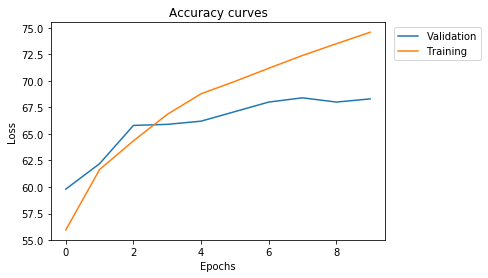

In [128]:
plt.plot(val_acc_hist,label='Validation')
plt.plot(train_acc_hist,label='Training')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Accuracy curves')
plt.show()    

#### (I realized that I made a mistake in my function where I divided unnecessarily by len(val_loader)) so this explains this part

In [71]:
for i in range(len(val_loss_hist)):
    val_loss_hist[i]=len(val_loader)*val_loss_hist[i]


## Plots

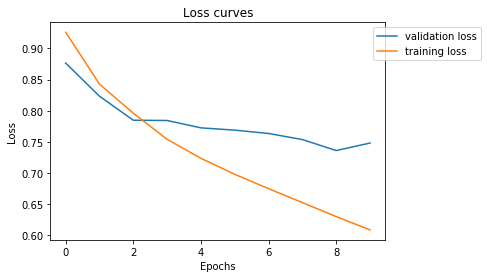

In [127]:
plt.plot(val_loss_hist,label='validation loss')
plt.plot(train_loss_hist,label='training loss')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss curves')
plt.show()    

## Let's add two more epochs, see what it yields

In [77]:
run_GRU(2,train_loader,val_loader,model,optimizer,criterion,
        val_loss_hist,train_loss_hist,val_acc_hist,train_acc_hist,epochs_already_made=10)

Epoch: [11/12], Step: [626/3125], 20.0% complete, Train Loss: 0.5822132798194886
Epoch: [11/12], Step: [1251/3125], 40.0% complete, Train Loss: 0.5787776690721512
Epoch: [11/12], Step: [1876/3125], 60.0% complete, Train Loss: 0.5844023666540782
Epoch: [11/12], Step: [2501/3125], 80.0% complete, Train Loss: 0.5861707503914833
Train loss: 0.5848422491741181
Val loss: 0.7432736055925488
Train acc: 75.688
Val acc: 68.8
Epoch: [12/12], Step: [626/3125], 20.0% complete, Train Loss: 0.5489340211868287
Epoch: [12/12], Step: [1251/3125], 40.0% complete, Train Loss: 0.5530880249738693
Epoch: [12/12], Step: [1876/3125], 60.0% complete, Train Loss: 0.5580213640530904
Epoch: [12/12], Step: [2501/3125], 80.0% complete, Train Loss: 0.5608117134034634
Train loss: 0.5616347882604599
Val loss: 0.7506650853902102
Train acc: 76.814
Val acc: 69.1


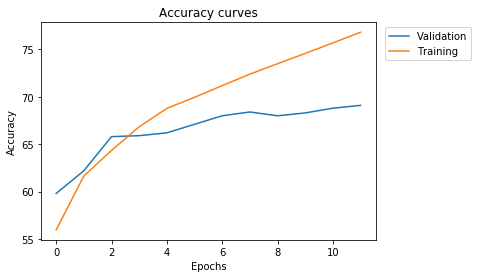

In [131]:
plt.plot(val_acc_hist,label='Validation')
plt.plot(train_acc_hist,label='Training')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy curves')
plt.show()    

In [133]:
for i in range(len(val_loss_hist[10:])):
    val_loss_hist[i]=len(val_loader)*val_loss_hist[i]

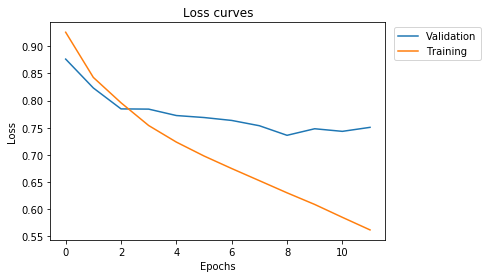

In [134]:
plt.plot(val_loss_hist,label='Validation')
plt.plot(train_loss_hist,label='Training')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss curves')
plt.show()    

#### Therefore, 10 epochs are enough to reach the minimal validation loss, so this way we won't overfit

# Hyperparameter search for GRU

## Let's try different hidden sizes for the GRU and the Linear part of our architecture

In [92]:
hidden_size=[128,256,512]
linear_hidden_size=[16,32,64,128]
train_loss_hist_dict={}
val_loss_hist_dict={}
train_acc_hist_dict={}
val_acc_hist_dict={}

iteration=0
for hidden_size_i in hidden_size:
    for linear_hidden_size_j in linear_hidden_size:
        train_loss_hist_hidden_size_i=[]
        val_loss_hist_hidden_size_i=[]
        train_acc_hist_hidden_size_i=[]
        val_acc_hist_hidden_size_i=[]


        model2 = TwoFullyConnectedLayers(embedding_words, hidden_size_GRU=hidden_size_i, 
                                     hidden_size_linear=linear_hidden_size_j, num_layers=1)
        optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)
        run_GRU(10,train_loader,val_loader,model2,optimizer2,criterion,val_loss_hist_hidden_size_i,
                train_loss_hist_hidden_size_i,val_acc_hist_hidden_size_i,train_acc_hist_hidden_size_i)
    
        train_loss_hist_dict[(hidden_size_i,linear_hidden_size_j)]=train_loss_hist_hidden_size_i
        val_loss_hist_dict[(hidden_size_i,linear_hidden_size_j)]=val_loss_hist_hidden_size_i
        train_acc_hist_dict[(hidden_size_i,linear_hidden_size_j)]=train_acc_hist_hidden_size_i
        val_acc_hist_dict[(hidden_size_i,linear_hidden_size_j)]=val_acc_hist_hidden_size_i
    
    sendmail(job='GRU for hidden_size='+str(hidden_size_i),percentage=100*(iteration+1)/len(hidden_size))
    iteration+=1

Epoch: [1/10], Step: [626/3125], 20.0% complete, Train Loss: 1.0370334352493287
Epoch: [1/10], Step: [1251/3125], 40.0% complete, Train Loss: 0.989620902299881
Epoch: [1/10], Step: [1876/3125], 60.0% complete, Train Loss: 0.9657803978919983
Epoch: [1/10], Step: [2501/3125], 80.0% complete, Train Loss: 0.9502657133102417
Train loss: 0.9364986214828491
Val loss: 0.8905322253704071
Train acc: 55.044
Val acc: 59.1
Epoch: [2/10], Step: [626/3125], 20.0% complete, Train Loss: 0.8719392838478088
Epoch: [2/10], Step: [1251/3125], 40.0% complete, Train Loss: 0.86592669839859
Epoch: [2/10], Step: [1876/3125], 60.0% complete, Train Loss: 0.861289337348938
Epoch: [2/10], Step: [2501/3125], 80.0% complete, Train Loss: 0.8589098029613494
Train loss: 0.8552949146270752
Val loss: 0.8411054778844118
Train acc: 61.041
Val acc: 61.8
Epoch: [3/10], Step: [626/3125], 20.0% complete, Train Loss: 0.8332415658950806
Epoch: [3/10], Step: [1251/3125], 40.0% complete, Train Loss: 0.8284549296140671
Epoch: [3/10]

KeyboardInterrupt: 

#### Due to the algorithm taking too long to compute, I stopped at 512 and only did one linear embedding size there, meaning I tested 9 different sizes

### Let's see the impact of hidden sizes

In [94]:
pkl.dump(train_loss_hist_dict,open('train_loss_hist_dict.p','wb'))
pkl.dump(val_loss_hist_dict,open('val_loss_hist_dict.p','wb'))
pkl.dump(train_acc_hist_dict,open('train_acc_hist_dict.p','wb'))
pkl.dump(val_acc_hist_dict,open('val_acc_hist_dict.p','wb'))

In [78]:
train_loss_hist_dict=pkl.load(open('train_loss_hist_dict.p','rb'))
val_loss_hist_dict=pkl.load(open('val_loss_hist_dict.p','rb'))
train_acc_hist_dict=pkl.load(open('train_acc_hist_dict.p','rb'))
val_acc_hist_dict=pkl.load(open('val_acc_hist_dict.p','rb'))

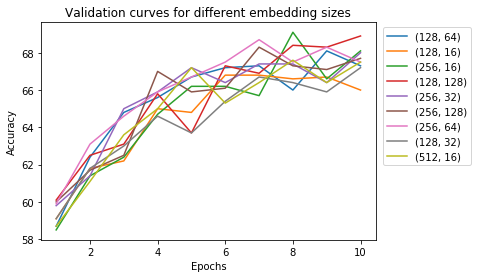

In [79]:
epochs_tab=[i+1 for i in range(10)]
for i in val_acc_hist_dict:
    plt.plot(epochs_tab,val_acc_hist_dict[i],label=str(i))
plt.legend(bbox_to_anchor=(1.3, 1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation curves for different embedding sizes')
plt.show()    

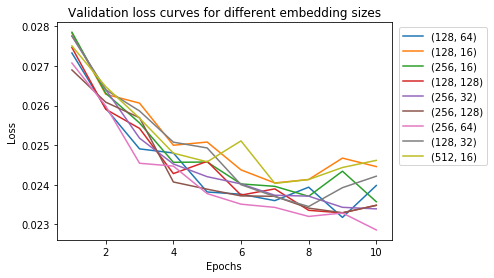

In [88]:
epochs_tab=[i+1 for i in range(10)]
for i in val_acc_hist_dict:
    plt.plot(epochs_tab,val_loss_hist_dict[i],label=str(i))
plt.legend(bbox_to_anchor=(1.3, 1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation loss curves for different embedding sizes')
plt.show()    

In [102]:
import operator
val_comparison={}
for key in val_acc_hist_dict:
    val_comparison[key] = val_acc_hist_dict[key][-1]
sorted_val_comparison = sorted(val_comparison.items(), key=lambda x: -x[1])
sorted_val_comparison

[((128, 128), 68.9),
 ((256, 16), 68.1),
 ((256, 32), 68.0),
 ((256, 128), 67.7),
 ((256, 64), 67.5),
 ((512, 16), 67.5),
 ((128, 64), 67.3),
 ((128, 32), 67.2),
 ((128, 16), 66.0)]

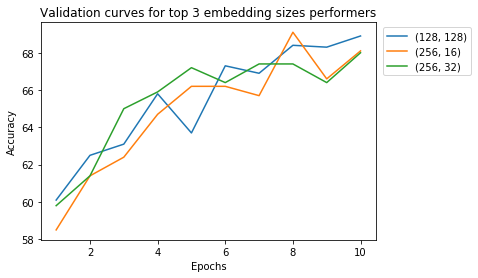

In [105]:
iterations=0
for key in sorted_val_comparison:
    plt.plot(epochs_tab,val_acc_hist_dict[key[0]],label=str(key[0]))
    iterations+=1
    if iterations==3:
        break
plt.legend(bbox_to_anchor=(1.3, 1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation curves for top 3 embedding sizes performers')
plt.show()    
    

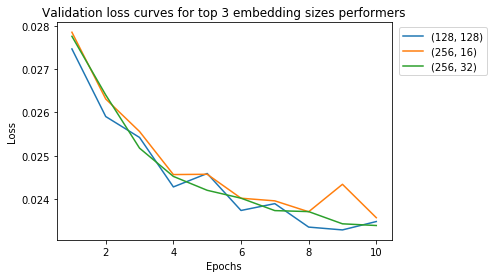

In [107]:
iterations=0
for key in sorted_val_comparison:
    plt.plot(epochs_tab,val_loss_hist_dict[key[0]],label=str(key[0]))
    iterations+=1
    if iterations==3:
        break
plt.legend(bbox_to_anchor=(1.3, 1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation loss curves for top 3 embedding sizes performers')
plt.show()    
    

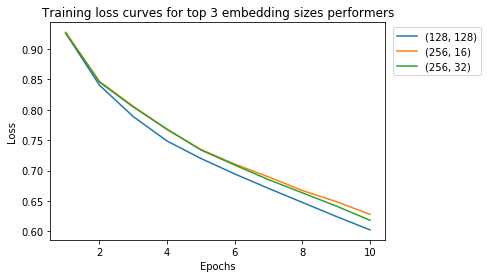

In [114]:
iterations=0
for key in sorted_val_comparison:
    plt.plot(epochs_tab,train_loss_hist_dict[key[0]],label=str(key[0]))
    iterations+=1
    if iterations==3:
        break
plt.legend(bbox_to_anchor=(1.3, 1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss curves for top 3 embedding sizes performers')
plt.show()    
    

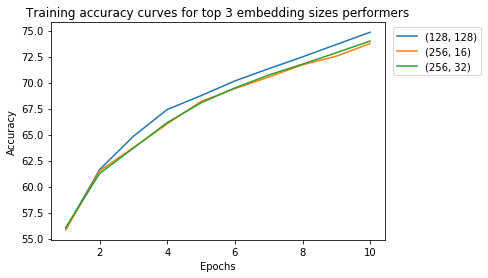

In [113]:
iterations=0
for key in sorted_val_comparison:
    plt.plot(epochs_tab,train_acc_hist_dict[key[0]],label=str(key[0]))
    iterations+=1
    if iterations==3:
        break
plt.legend(bbox_to_anchor=(1.3, 1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy curves for top 3 embedding sizes performers')
plt.show()    
    

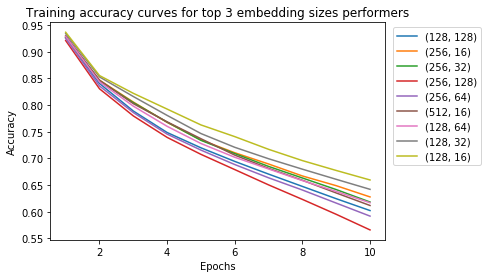

In [117]:
for key in sorted_val_comparison:
    plt.plot(epochs_tab,train_loss_hist_dict[key[0]],label=str(key[0]))
plt.legend(bbox_to_anchor=(1.3, 1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy curves for top 3 embedding sizes performers')
plt.show()    
    

The best choice is 128 for both hidden sizes

## Let's test the dropout

In [58]:
class GRU_dropout(nn.Module):
    def __init__(self, ft_embeddings, hidden_size, num_layers,dropout):
        super().__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(ft_embeddings).float())
        self.gru = nn.GRU(300, hidden_size, num_layers,dropout=dropout,bidirectional=True, batch_first=True)
        
        
    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(2*self.num_layers, batch_size, self.hidden_size)
        return hidden

    def forward(self, x, lengths):
        # reset hidden state

        batch_size, seq_len = x.size()
        self.hidden = self.init_hidden(batch_size)

        # get embedding of characters
        embed = self.embedding(x)
        #sorting the lengths
        indices=pd.Series(lengths).sort_values(ascending=False).index
        embed=embed[indices]
        lengths=lengths[indices]
        # pack padded sequence
        embed = torch.nn.utils.rnn.pack_padded_sequence(embed, (lengths.numpy()), batch_first=True)
        # fprop though RNN
        gru_out, self.hidden = self.gru(embed, self.hidden)
        # undo packing
        gru_out = self.hidden
        #reorder output
        inverse_permutation=pd.Series(indices).sort_values(ascending=True).index
        forward_output=gru_out[0]
        backward_output=gru_out[1]
        output=torch.cat((forward_output,backward_output),dim=1)
        output=output[inverse_permutation]
        return output




In [59]:
class TwoFullyConnectedLayers_dropout(nn.Module):
    def __init__(self, ft_embeddings, hidden_size_GRU,hidden_size_linear, dropout, num_layers,num_classes=3):
        super().__init__()

        self.gru_premise=GRU_dropout(ft_embeddings,hidden_size_GRU,num_layers,dropout=dropout)
        self.gru_hypothesis=GRU_dropout(ft_embeddings,hidden_size_GRU,num_layers,dropout=dropout)
        #concatenate the two outputs of size 2*hidden_size
        self.linear1=nn.Linear(2*(2*hidden_size_GRU),hidden_size_linear)  
        self.linear2=nn.Linear(hidden_size_linear,num_classes)
        
        
    def forward(self, premise,length_premise,hypothesis,length_hypothesis):
        # reset hidden state
        
        output_premise=self.gru_premise(premise,length_premise)
        output_hypothesis=self.gru_hypothesis(hypothesis,length_hypothesis)
        
        output=torch.cat((output_premise,output_hypothesis),dim=1)
        
        x=self.linear1(output)
        x=nn.functional.relu(x)
        x=self.linear2(x)
        
        return x

In [119]:
dropout_i=0.5
train_loss_hist_dropout_i=[]
val_loss_hist_dropout_i=[]
train_acc_hist_dropout_i=[]
val_acc_hist_dropout_i=[]


model3 = TwoFullyConnectedLayers_dropout(embedding_words, hidden_size_GRU=128,
                                         hidden_size_linear=128, dropout=dropout_i,num_layers=1)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=learning_rate)
run_GRU(10,train_loader,val_loader,model3,optimizer3,criterion,val_loss_hist_dropout_i,
        train_loss_hist_dropout_i,val_acc_hist_dropout_i,train_acc_hist_dropout_i)

sendmail(job='GRU dropout='+str(dropout_i),percentage=100*iteration/3)

Epoch: [1/10], Step: [626/3125], 20.0% complete, Train Loss: 1.0134870886802674
Epoch: [1/10], Step: [1251/3125], 40.0% complete, Train Loss: 0.973672735786438
Epoch: [1/10], Step: [1876/3125], 60.0% complete, Train Loss: 0.9506432129542033
Epoch: [1/10], Step: [2501/3125], 80.0% complete, Train Loss: 0.9360220637559891
Train loss: 0.9247695468521118
Val loss: 0.876868799328804
Train acc: 56.075
Val acc: 59.3
Epoch: [2/10], Step: [626/3125], 20.0% complete, Train Loss: 0.8564696901321411
Epoch: [2/10], Step: [1251/3125], 40.0% complete, Train Loss: 0.852050843667984
Epoch: [2/10], Step: [1876/3125], 60.0% complete, Train Loss: 0.8477626754919688
Epoch: [2/10], Step: [2501/3125], 80.0% complete, Train Loss: 0.8425393963575363
Train loss: 0.8381547678279877
Val loss: 0.8178883604705334
Train acc: 61.903
Val acc: 63.2
Epoch: [3/10], Step: [626/3125], 20.0% complete, Train Loss: 0.793329447555542
Epoch: [3/10], Step: [1251/3125], 40.0% complete, Train Loss: 0.7974343042850495
Epoch: [3/10]

//anaconda/lib/python3.5/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [122]:
pkl.dump(train_loss_hist_dropout_i,open('train_loss_hist_dropout_i.p','wb'))
pkl.dump(val_loss_hist_dropout_i,open('val_loss_hist_dropout_i.p','wb'))
pkl.dump(train_acc_hist_dropout_i,open('train_acc_hist_dropout_i.p','wb'))

pkl.dump(val_acc_hist_dropout_i,open('val_acc_hist_dropout_i.p','wb'))

In [68]:
train_loss_hist_dropout_i = pkl.load(open('train_loss_hist_dropout_i.p','rb'))
val_loss_hist_dropout_i   = pkl.load(open('val_loss_hist_dropout_i.p','rb'))
train_acc_hist_dropout_i  = pkl.load(open('train_acc_hist_dropout_i.p','rb'))
val_acc_hist_dropout_i    = pkl.load(open('val_acc_hist_dropout_i.p','rb'))

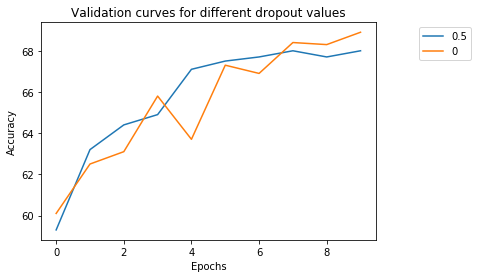

In [69]:
plt.plot(val_acc_hist_dropout_i,label='0.5')
plt.plot(val_acc_hist_dict[(128,128)],label='0')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation curves for different dropout values')
plt.show()    

We will keep Dropout=0

# Let's now build the CNN encoder and the corresponding architecture

In [60]:
class CNN(nn.Module):
    def __init__(self, ft_embeddings, hidden_size, num_layers,kernel_dim,padding=1 ):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(ft_embeddings).float())
    
        self.conv1 = nn.Conv1d(300, hidden_size, kernel_size=kernel_dim, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_dim, padding=1)


    def forward(self, x, lengths):
        batch_size, seq_len = x.size()

        embed = self.embedding(x)
        hidden = self.conv1(embed.transpose(1,2)).transpose(1,2)
        hidden = nn.functional.relu(hidden.contiguous().view(-1, hidden.size(-1))).view(batch_size, seq_len, hidden.size(-1))

        hidden = self.conv2(hidden.transpose(1,2)).transpose(1,2)
        hidden = nn.functional.relu(hidden.contiguous().view(-1, hidden.size(-1))).view(batch_size, seq_len, hidden.size(-1))

        hidden = torch.sum(hidden, dim=1)

        return hidden

In [61]:
class TwoFullyConnectedLayers_CNN(nn.Module):
    def __init__(self, ft_embeddings, hidden_size_CNN,hidden_size_linear,kernel_dim,num_layers,padding=1,num_classes=3):
        super().__init__()

        self.conv_premise=CNN(ft_embeddings, hidden_size_CNN,num_layers,kernel_dim,padding=padding)
        self.conv_hypothesis=CNN(ft_embeddings, hidden_size_CNN,num_layers,kernel_dim,padding=padding)

        self.linear1=nn.Linear((2*hidden_size_CNN),hidden_size_linear)  
        self.linear2=nn.Linear(hidden_size_linear,num_classes)
        
        
    def forward(self, premise,length_premise,hypothesis,length_hypothesis):
        # reset hidden state
        
        output_premise=self.conv_premise(premise,length_premise)
        output_hypothesis=self.conv_hypothesis(hypothesis,length_hypothesis)
        
        output=torch.cat((output_premise,output_hypothesis),dim=1)
        output = output.view(output.size(0), -1)
        x=self.linear1(output)
        x=nn.functional.relu(x)
        x=self.linear2(x)
        
        return x

In [62]:
def run_CNN(num_epochs,train_loader,val_loader,model,optimizer,criterion,
            val_loss_hist,train_loss_hist,val_acc_hist,train_acc_hist,epochs_already_made=0):
    train_loss=0
    val_loss=0
    for epoch in range(num_epochs):
        total=0
        correct=0
        for i, batch in enumerate(train_loader):
            data_premise=batch[0]
            data_hypothesis=batch[1]
            length_premise=batch[2]
            length_hypothesis=batch[3]
            labels=batch[4]
        
        
            model.train()
            optimizer.zero_grad()
        

            # Forward pass
            outputs = model(data_premise, length_premise,data_hypothesis,length_hypothesis)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()
            predicted = outputs.max(1, keepdim=True)[1]

            total += labels.size(0)
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
            
            if i > 0 and i % 625 == 0:
    
                # validate
                print('Epoch: [{}/{}], Step: [{}/{}], {}% complete, Train Loss: {}'.format(
                    epoch+epochs_already_made+1, num_epochs+epochs_already_made, 
                    i+1, len(train_loader),100*i/len(train_loader), train_loss/i))
    
        val_acc,val_loss= test_model(val_loader, model,val_loss)
        train_acc=(100 * correct / total)
    
        print('Train loss: '+str(train_loss/len(train_loader)))
        print('Val loss: '+str(val_loss))
        print('Train acc: '+str(train_acc))
        print('Val acc: '+str(val_acc))
        val_loss_hist.append(val_loss)
        train_loss_hist.append(train_loss/len(train_loader))
        val_acc_hist.append(val_acc)
        train_acc_hist.append(train_acc)
    
        train_loss=0
        val_loss=0

In [189]:
model_CNN = TwoFullyConnectedLayers_CNN(embedding_words, hidden_size_CNN=128, 
                                        hidden_size_linear=128,kernel_dim=3,num_layers=2)
learning_rate = 3e-4
num_epochs = 10 # number epoch to train
criterion = torch.nn.CrossEntropyLoss()
optimizer_CNN = torch.optim.Adam(model_CNN.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
train_loss_hist_CNN=[]
val_loss_hist_CNN=[]
train_acc_hist_CNN=[]
val_acc_hist_CNN=[]

run_CNN(10,train_loader,val_loader,model_CNN,optimizer_CNN,criterion,val_loss_hist_CNN,
        train_loss_hist_CNN,val_acc_hist_CNN,train_acc_hist_CNN)

Epoch: [1/10], Step: [626/3125], 20.0% complete, Train Loss: 0.9864598099708557
Epoch: [1/10], Step: [1251/3125], 40.0% complete, Train Loss: 0.935823431968689
Epoch: [1/10], Step: [1876/3125], 60.0% complete, Train Loss: 0.9098875854174296
Epoch: [1/10], Step: [2501/3125], 80.0% complete, Train Loss: 0.890300645327568
Train loss: 0.874419735622406
Val loss: 0.8301022369414568
Train acc: 59.386
Val acc: 63.2
Epoch: [2/10], Step: [626/3125], 20.0% complete, Train Loss: 0.7803836817741394
Epoch: [2/10], Step: [1251/3125], 40.0% complete, Train Loss: 0.7750780759334565
Epoch: [2/10], Step: [1876/3125], 60.0% complete, Train Loss: 0.7702866414546966
Epoch: [2/10], Step: [2501/3125], 80.0% complete, Train Loss: 0.7701415434241294
Train loss: 0.7667774828910827
Val loss: 0.797573110088706
Train acc: 66.267
Val acc: 65.0
Epoch: [3/10], Step: [626/3125], 20.0% complete, Train Loss: 0.7124189651966095
Epoch: [3/10], Step: [1251/3125], 40.0% complete, Train Loss: 0.7164032210588456
Epoch: [3/10]

In [190]:
sendmail(job='CNN')

### (I had to shutdown the kernel as some function I was trying made it crash, thankfully I printed all the losses and accuracies at each epoch so I just had to copy paste them)

In [125]:
train_loss_hist_CNN =[0.874419735622406,0.7667774828910827,0.7148594392204285,0.6694753368759155,
                      0.6210757782363892,0.5775430456781387,0.533324829120636,0.48930007195949554,
                      0.44834216572761537,0.40885074420690537]

val_loss_hist_CNN = [0.8301022369414568,0.797573110088706,0.7929401816800237,0.7811199836432934,
                     0.7819704413414001,0.8231707373633981,0.8475095881149173,0.835559600032866,
                     0.9984435196965933,0.9776945970952511]


train_acc_hist_CNN=[59.386,66.267,69.175,71.58,74.167,76.189,78.357,80.437,82.168,83.966]

val_acc_hist_CNN=[63.2,65.0,64.4,65.5,66.2,67.2,65.8,67.2,65.2,66.7]

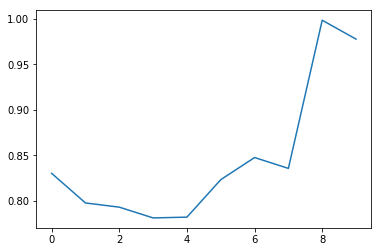

In [126]:
plt.plot(val_loss_hist_CNN)

#### It seems that 10 epochs is even too much for CNN, we'll confirm that with the following hyperparameter search

In [74]:
train_loss_hist_CNN_dict={3: train_loss_hist_CNN}
val_loss_hist_CNN_dict={3: val_loss_hist_CNN}
train_acc_hist_CNN_dict={3: train_acc_hist_CNN}
val_acc_hist_CNN_dict={3: val_acc_hist_CNN}

## Element-wise multiplication vs concatenation

In [63]:
class TwoFullyConnectedLayers_CNN_multiplication(nn.Module):
    def __init__(self, ft_embeddings, hidden_size_CNN,hidden_size_linear,kernel_dim,num_layers,padding=1,num_classes=3):
        super().__init__()

        self.conv_premise=CNN(ft_embeddings, hidden_size_CNN,num_layers,kernel_dim,padding=padding)
        self.conv_hypothesis=CNN(ft_embeddings, hidden_size_CNN,num_layers,kernel_dim,padding=padding)

        self.linear1=nn.Linear((hidden_size_CNN),hidden_size_linear)  
        self.linear2=nn.Linear(hidden_size_linear,num_classes)
        
        
    def forward(self, premise,length_premise,hypothesis,length_hypothesis):
        # reset hidden state
        
        output_premise=self.conv_premise(premise,length_premise)
        output_hypothesis=self.conv_hypothesis(hypothesis,length_hypothesis)
        
        output=output_premise*output_hypothesis
        output = output.view(output.size(0), -1)
        x=self.linear1(output)
        x=nn.functional.relu(x)
        x=self.linear2(x)
        
        return x

In [117]:
learning_rate = 3e-4

model_CNN_new = TwoFullyConnectedLayers_CNN_multiplication(embedding_words, hidden_size_CNN=128, 
                                        hidden_size_linear=128,kernel_dim=3,num_layers=2)
optimizer_CNN_new = torch.optim.Adam(model_CNN_new.parameters(), lr=learning_rate)

train_loss_hist_CNN_new=[]
val_loss_hist_CNN_new=[]
train_acc_hist_CNN_new=[]
val_acc_hist_CNN_new=[]

run_CNN(10,train_loader,val_loader,model_CNN_new,optimizer_CNN_new,criterion,val_loss_hist_CNN_new,
        train_loss_hist_CNN_new,val_acc_hist_CNN_new,train_acc_hist_CNN_new)

sendmail(job='Elementwise mult hyperparameter search')

Epoch: [1/10], Step: [626/3125], 20.0% complete, Train Loss: 0.974441980934143
Epoch: [1/10], Step: [1251/3125], 40.0% complete, Train Loss: 0.930144678735733
Epoch: [1/10], Step: [1876/3125], 60.0% complete, Train Loss: 0.9017800320625305
Epoch: [1/10], Step: [2501/3125], 80.0% complete, Train Loss: 0.8802479664564132
Train loss: 0.8645651511383057
Val loss: 0.8168021328747272
Train acc: 60.021
Val acc: 64.5
Epoch: [2/10], Step: [626/3125], 20.0% complete, Train Loss: 0.7592399186134339
Epoch: [2/10], Step: [1251/3125], 40.0% complete, Train Loss: 0.7584833955526352
Epoch: [2/10], Step: [1876/3125], 60.0% complete, Train Loss: 0.757425253423055
Epoch: [2/10], Step: [2501/3125], 80.0% complete, Train Loss: 0.7544688121914863
Train loss: 0.7503852749252319
Val loss: 0.7816677186638117
Train acc: 67.064
Val acc: 65.7
Epoch: [3/10], Step: [626/3125], 20.0% complete, Train Loss: 0.6870643859863281
Epoch: [3/10], Step: [1251/3125], 40.0% complete, Train Loss: 0.6881650052547454
Epoch: [3/10

In [118]:
pkl.dump(train_loss_hist_CNN_new,open('train_loss_hist_CNN_elementwise_mult.p','wb'))
pkl.dump(val_loss_hist_CNN_new,open('val_loss_hist_CNN_elementwise_mult.p','wb'))
pkl.dump(train_acc_hist_CNN_new,open('train_acc_hist_CNN_elementwise_mult.p','wb'))

pkl.dump(val_acc_hist_CNN_new,open('val_acc_hist_CNN_elementwise_mult.p','wb'))

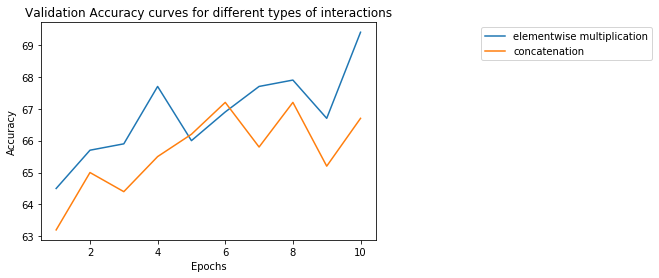

In [128]:
plt.plot(epochs_tab,val_acc_hist_CNN_new,label='elementwise multiplication')
plt.plot(epochs_tab,val_acc_hist_CNN,label='concatenation')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy curves for different types of interactions')
plt.show()    

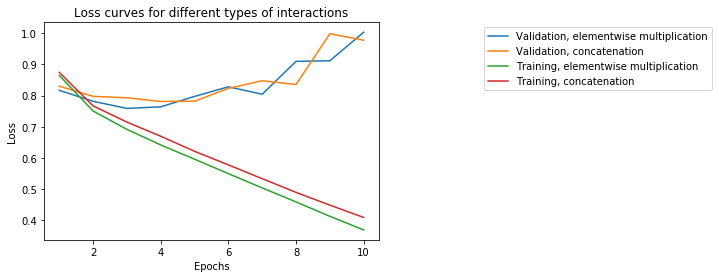

In [133]:
plt.plot(epochs_tab,val_loss_hist_CNN_new,label='Validation, elementwise multiplication')
plt.plot(epochs_tab,val_loss_hist_CNN,label='Validation, concatenation')
plt.plot(epochs_tab,train_loss_hist_CNN_new,label='Training, elementwise multiplication')
plt.plot(epochs_tab,train_loss_hist_CNN,label='Training, concatenation')


plt.legend(bbox_to_anchor=(1.3, 1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss curves for different types of interactions')
plt.show()    

It seems that 10 epochs seem to be enough for the model to overfit the data given how the validation loss decreases then increases again. However, 10 epochs seemed to allow a better accuracy. We will therefore go for 7 epochs for CNN, and also will use elementwise multiplication, which seems to yield better results and achieves above 65% accuracy

In [134]:
val_acc_hist_CNN_new[6]

67.7

## Hidden size hyperparameter tuning

We will keep 128 for the linear hidden size and will only play with the CNN hidden size, try a size of 32 and 64 instead of 128

In [66]:
model_CNN_new = TwoFullyConnectedLayers_CNN_multiplication(embedding_words, hidden_size_CNN=32, 
                                            hidden_size_linear=128,kernel_dim=3,num_layers=2)
optimizer_CNN_new = torch.optim.Adam(model_CNN_new.parameters(), lr=learning_rate)

train_loss_hist_CNN_32=[]
val_loss_hist_CNN_32=[]
train_acc_hist_32=[]
val_acc_hist_CNN_32=[]

run_CNN(7,train_loader,val_loader,model_CNN_new,optimizer_CNN_new,criterion,val_loss_hist_CNN_32,
            train_loss_hist_CNN_32,val_acc_hist_CNN_32,train_acc_hist_32)

sendmail(job='Hidden size CNN=32')


Epoch: [1/7], Step: [626/3125], 20.0% complete, Train Loss: 1.0839206120491027
Epoch: [1/7], Step: [1251/3125], 40.0% complete, Train Loss: 1.0071523975372314
Epoch: [1/7], Step: [1876/3125], 60.0% complete, Train Loss: 0.9676911164601644
Epoch: [1/7], Step: [2501/3125], 80.0% complete, Train Loss: 0.9401409344911575
Train loss: 0.9204122310447693
Val loss: 0.8795625921338797
Train acc: 56.159
Val acc: 60.0
Epoch: [2/7], Step: [626/3125], 20.0% complete, Train Loss: 0.8109404601573944
Epoch: [2/7], Step: [1251/3125], 40.0% complete, Train Loss: 0.8076492828607559
Epoch: [2/7], Step: [1876/3125], 60.0% complete, Train Loss: 0.8049521133263906
Epoch: [2/7], Step: [2501/3125], 80.0% complete, Train Loss: 0.8011808154821396
Train loss: 0.7979427389907837
Val loss: 0.8438805416226387
Train acc: 64.326
Val acc: 62.1
Epoch: [3/7], Step: [626/3125], 20.0% complete, Train Loss: 0.7656810951709747
Epoch: [3/7], Step: [1251/3125], 40.0% complete, Train Loss: 0.7595814868927002
Epoch: [3/7], Step:

#### (Kernel issue again... copy/pasted again)

In [68]:
val_acc_hist_CNN_128=[64.5,65.7,65.9,67.7,66.0,66.9,67.7]

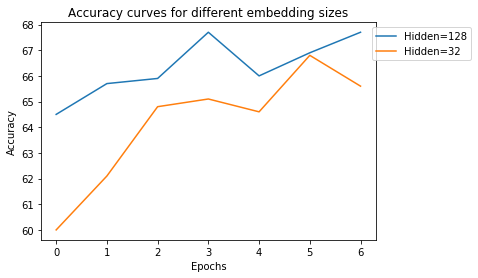

In [72]:
plt.plot(val_acc_hist_CNN_128,label='Hidden=128')
plt.plot(val_acc_hist_CNN_32,label='Hidden=32')

plt.legend(bbox_to_anchor=(1.3, 1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy curves for different embedding sizes')
plt.show()    

In [70]:
model_CNN_new = TwoFullyConnectedLayers_CNN_multiplication(embedding_words, hidden_size_CNN=64, 
                                            hidden_size_linear=128,kernel_dim=3,num_layers=2)
optimizer_CNN_new = torch.optim.Adam(model_CNN_new.parameters(), lr=learning_rate)

train_loss_hist_CNN_64=[]
val_loss_hist_CNN_64=[]
train_acc_hist_64=[]
val_acc_hist_CNN_64=[]

run_CNN(7,train_loader,val_loader,model_CNN_new,optimizer_CNN_new,criterion,val_loss_hist_CNN_64,
            train_loss_hist_CNN_64,val_acc_hist_CNN_64,train_acc_hist_64)

sendmail(job='Hidden size CNN=64')



Epoch: [1/7], Step: [626/3125], 20.0% complete, Train Loss: 0.9878928596496582
Epoch: [1/7], Step: [1251/3125], 40.0% complete, Train Loss: 0.940680060338974
Epoch: [1/7], Step: [1876/3125], 60.0% complete, Train Loss: 0.9138473311742147
Epoch: [1/7], Step: [2501/3125], 80.0% complete, Train Loss: 0.8942862898945808
Train loss: 0.8788442888450623
Val loss: 0.8248213827610016
Train acc: 59.029
Val acc: 64.6
Epoch: [2/7], Step: [626/3125], 20.0% complete, Train Loss: 0.7932269283294677
Epoch: [2/7], Step: [1251/3125], 40.0% complete, Train Loss: 0.783582415342331
Epoch: [2/7], Step: [1876/3125], 60.0% complete, Train Loss: 0.7812625375429789
Epoch: [2/7], Step: [2501/3125], 80.0% complete, Train Loss: 0.7776470948815346
Train loss: 0.7737949680805206
Val loss: 0.7955921608954668
Train acc: 65.805
Val acc: 65.3
Epoch: [3/7], Step: [626/3125], 20.0% complete, Train Loss: 0.732725119638443
Epoch: [3/7], Step: [1251/3125], 40.0% complete, Train Loss: 0.7265343331813813
Epoch: [3/7], Step: [1

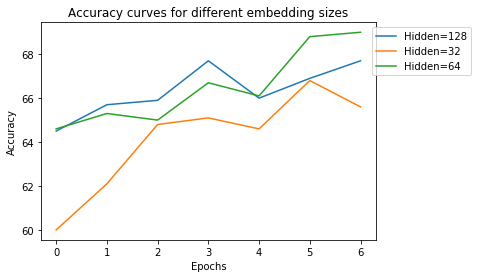

In [73]:
plt.plot(val_acc_hist_CNN_128,label='Hidden=128')
plt.plot(val_acc_hist_CNN_32,label='Hidden=32')
plt.plot(val_acc_hist_CNN_64,label='Hidden=64')

plt.legend(bbox_to_anchor=(1.3, 1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy curves for different embedding sizes')
plt.show()    

Therefore, we'll use a hidden size of 64

## Hidden size for linear layers

In [74]:
model_CNN_new = TwoFullyConnectedLayers_CNN_multiplication(embedding_words, hidden_size_CNN=64, 
                                            hidden_size_linear=32,kernel_dim=3,num_layers=2)
optimizer_CNN_new = torch.optim.Adam(model_CNN_new.parameters(), lr=learning_rate)

train_loss_hist_CNN_linear32=[]
val_loss_hist_CNN_linear32=[]
train_acc_hist_linear32=[]
val_acc_hist_CNN_linear32=[]

run_CNN(7,train_loader,val_loader,model_CNN_new,optimizer_CNN_new,criterion,val_loss_hist_CNN_linear32,
            train_loss_hist_CNN_linear32,val_acc_hist_CNN_linear32,train_acc_hist_linear32)

sendmail(job='Linear hidden size CNN=32')




Epoch: [1/7], Step: [626/3125], 20.0% complete, Train Loss: 0.9878030947685241
Epoch: [1/7], Step: [1251/3125], 40.0% complete, Train Loss: 0.9421731632232666
Epoch: [1/7], Step: [1876/3125], 60.0% complete, Train Loss: 0.9164813541412353
Epoch: [1/7], Step: [2501/3125], 80.0% complete, Train Loss: 0.8982973393678665
Train loss: 0.8833797476577758
Val loss: 0.8336609825491905
Train acc: 58.66
Val acc: 61.4
Epoch: [2/7], Step: [626/3125], 20.0% complete, Train Loss: 0.7967143176078796
Epoch: [2/7], Step: [1251/3125], 40.0% complete, Train Loss: 0.7877820464849472
Epoch: [2/7], Step: [1876/3125], 60.0% complete, Train Loss: 0.7857418705463409
Epoch: [2/7], Step: [2501/3125], 80.0% complete, Train Loss: 0.7814130500912666
Train loss: 0.7788263490295411
Val loss: 0.8054065592586994
Train acc: 65.513
Val acc: 64.4
Epoch: [3/7], Step: [626/3125], 20.0% complete, Train Loss: 0.7323579814434051
Epoch: [3/7], Step: [1251/3125], 40.0% complete, Train Loss: 0.7346533383131028
Epoch: [3/7], Step: 

In [75]:
model_CNN_new = TwoFullyConnectedLayers_CNN_multiplication(embedding_words, hidden_size_CNN=64, 
                                            hidden_size_linear=64,kernel_dim=3,num_layers=2)
optimizer_CNN_new = torch.optim.Adam(model_CNN_new.parameters(), lr=learning_rate)

train_loss_hist_CNN_linear64=[]
val_loss_hist_CNN_linear64=[]
train_acc_hist_linear64=[]
val_acc_hist_CNN_linear64=[]

run_CNN(7,train_loader,val_loader,model_CNN_new,optimizer_CNN_new,criterion,val_loss_hist_CNN_linear64,
            train_loss_hist_CNN_linear64,val_acc_hist_CNN_linear64,train_acc_hist_linear64)

sendmail(job='Linear hidden size CNN=64')

Epoch: [1/7], Step: [626/3125], 20.0% complete, Train Loss: 0.9892379689216614
Epoch: [1/7], Step: [1251/3125], 40.0% complete, Train Loss: 0.941840809392929
Epoch: [1/7], Step: [1876/3125], 60.0% complete, Train Loss: 0.9131001475016276
Epoch: [1/7], Step: [2501/3125], 80.0% complete, Train Loss: 0.8938878628492355
Train loss: 0.8778835157585144
Val loss: 0.8225448746234179
Train acc: 59.042
Val acc: 63.6
Epoch: [2/7], Step: [626/3125], 20.0% complete, Train Loss: 0.78622550740242
Epoch: [2/7], Step: [1251/3125], 40.0% complete, Train Loss: 0.7803312185525895
Epoch: [2/7], Step: [1876/3125], 60.0% complete, Train Loss: 0.7801056182384491
Epoch: [2/7], Step: [2501/3125], 80.0% complete, Train Loss: 0.7744271592974663
Train loss: 0.7710212256813049
Val loss: 0.8085887413471937
Train acc: 65.916
Val acc: 63.1
Epoch: [3/7], Step: [626/3125], 20.0% complete, Train Loss: 0.7243483044147492
Epoch: [3/7], Step: [1251/3125], 40.0% complete, Train Loss: 0.7236133959054947
Epoch: [3/7], Step: [1

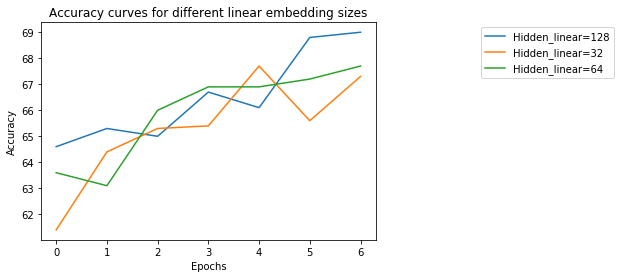

In [76]:
plt.plot(val_acc_hist_CNN_64,label='Hidden_linear=128')
plt.plot(val_acc_hist_CNN_linear32,label='Hidden_linear=32')
plt.plot(val_acc_hist_CNN_linear64,label='Hidden_linear=64')

plt.legend(bbox_to_anchor=(1.3, 1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy curves for different linear embedding sizes')
plt.show()    

# Let's prepare the MultiNLI validation set

In [64]:
val_data_mnli=pd.read_csv('mnli_val.tsv',sep='\t')

In [65]:
val_data_mnli['genre'].unique()

array(['fiction', 'telephone', 'slate', 'government', 'travel'],
      dtype=object)

In [66]:
val_data_fiction=val_data_mnli[val_data_mnli['genre']=='fiction']

In [67]:
val_data_telephone=val_data_mnli[val_data_mnli['genre']=='telephone']

In [68]:
val_data_slate=val_data_mnli[val_data_mnli['genre']=='slate']

In [69]:
val_data_gov=val_data_mnli[val_data_mnli['genre']=='government']

In [70]:
val_data_travel=val_data_mnli[val_data_mnli['genre']=='travel']

In [71]:
def tokenize_dataset_MNLI(dataset):
    dataset_premise=dataset['sentence1']
    dataset_hypothesis=dataset['sentence2']
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    token_dataset_premise=[]
    token_dataset_hypothesis=[]
    for i in dataset_premise.index:
        tokens_premise=tokenize(dataset_premise[i])
        tokens_hypothesis=tokenize(dataset_hypothesis[i])
        
        token_dataset_premise.append(tokens_premise)
        token_dataset_hypothesis.append(tokens_hypothesis)
        
        all_tokens += tokens_premise
        all_tokens += tokens_hypothesis
        
    token_dataset=[token_dataset_premise,token_dataset_hypothesis]
    return token_dataset, all_tokens




In [72]:
#val_tokens_fiction, _=tokenize_dataset_MNLI(val_data_fiction)

In [73]:
#val_tokens_telephone, _=tokenize_dataset_MNLI(val_data_telephone)
#val_tokens_slate, _=tokenize_dataset_MNLI(val_data_slate)
#val_tokens_gov, _=tokenize_dataset_MNLI(val_data_gov)
#val_tokens_travel, _=tokenize_dataset_MNLI(val_data_travel)

In [74]:
#pkl.dump(val_tokens_fiction,open('val_tokens_fiction.p','wb'))
#pkl.dump(val_tokens_telephone,open('val_tokens_telephone.p','wb'))
#pkl.dump(val_tokens_slate,open('val_tokens_slate.p','wb'))
#pkl.dump(val_tokens_gov,open('val_tokens_gov.p','wb'))
#pkl.dump(val_tokens_travel,open('val_tokens_travel.p','wb'))

In [75]:
val_tokens_fiction   = pkl.load(open('val_tokens_fiction.p','rb'))
val_tokens_telephone = pkl.load(open('val_tokens_telephone.p','rb'))
val_tokens_slate     = pkl.load(open('val_tokens_slate.p','rb'))
val_tokens_gov       = pkl.load(open('val_tokens_gov.p','rb'))
val_tokens_travel    = pkl.load(open('val_tokens_travel.p','rb'))

In [76]:
r=random.randint(0,len(val_tokens_fiction[0]))
print(val_tokens_fiction[0][r])
print(val_tokens_fiction[1][r])
print(val_data_fiction.iloc[r])
val_target_fiction=val_data_fiction['label']
print(val_target_fiction.iloc[r])

['overlapping', 'the', 'others']
['overlapping', 'the', 'other', 'photos']
sentence1          Overlapping the others ?
sentence2    Overlapping the other photos ?
label                               neutral
genre                               fiction
Name: 257, dtype: object
neutral


In [77]:
r=random.randint(0,len(val_tokens_telephone[0]))
print(val_tokens_telephone[0][r])
print(val_tokens_telephone[1][r])
print(val_data_telephone.iloc[r])
val_target_telephone=val_data_telephone['label']
print(val_target_telephone.iloc[r])

['yeah', 'so', 'it', "'s", 'easy', 'to', 'do', 'i', 'm', 'actually', 'interested', 'in', 'getting', 'one', 'of', 'those', 'kind', 'of', 'my', 'wife', 'has', 'been', 'talking', 'about', 'this', 'in', 'the', 'past', 'couple', 'of', 'years', 'one', 'of', 'those', 'kind', 'of', 'campers', 'that', 'pop', 'up', 'so', 'it', "'s", 'about', 'uh', 'maybe', 'eight', 'foot', 'square', 'and', 'but', 'only', 'about', 'two', 'feet', 'tall', 'and', 'when', 'you', 'get', 'to', 'where', 'you', "'re", 'going', 'it', 'raises', 'up', 'and', 'there', "'s", 'tenting', 'material']
['i', 'want', 'to', 'get', 'one', 'of', 'those', 'campers']
sentence1    yeah so it 's easy to do i 'm actually interes...
sentence2                 I want to get one of those campers .
label                                               entailment
genre                                                telephone
Name: 1480, dtype: object
entailment


In [78]:
val_target_gov=val_data_gov['label']
val_target_slate=val_data_slate['label']
val_target_travel=val_data_travel['label']

In [79]:
val_target_fiction=np.array(val_target_fiction.replace('neutral',0).replace('entailment',1).replace('contradiction',2))
val_target_telephone=np.array(val_target_telephone.replace('neutral',0).replace('entailment',1).replace('contradiction',2))
val_target_gov=np.array(val_target_gov.replace('neutral',0).replace('entailment',1).replace('contradiction',2))
val_target_slate=np.array(val_target_slate.replace('neutral',0).replace('entailment',1).replace('contradiction',2))
val_target_travel=np.array(val_target_travel.replace('neutral',0).replace('entailment',1).replace('contradiction',2))

In [80]:
val_fiction_premise_indices=token2index_dataset(val_tokens_fiction[0])
val_fiction_hypothesis_indices=token2index_dataset(val_tokens_fiction[1])
val_fiction_indices=[]
for i in range(len(val_fiction_premise_indices)):
    t_i=[val_fiction_premise_indices[i],val_fiction_hypothesis_indices[i]]
    val_fiction_indices.append(t_i)
    
val_fiction_dataset = NewsGroupDataset(val_fiction_indices, val_target_fiction)
val_fiction_loader=torch.utils.data.DataLoader(dataset=val_fiction_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)

In [81]:
val_telephone_premise_indices=token2index_dataset(val_tokens_telephone[0])
val_telephone_hypothesis_indices=token2index_dataset(val_tokens_telephone[1])
val_telephone_indices=[]
for i in range(len(val_telephone_premise_indices)):
    t_i=[val_telephone_premise_indices[i],val_telephone_hypothesis_indices[i]]
    val_telephone_indices.append(t_i)
    
val_telephone_dataset = NewsGroupDataset(val_telephone_indices, val_target_telephone)
val_telephone_loader=torch.utils.data.DataLoader(dataset=val_telephone_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)

In [82]:
val_gov_premise_indices=token2index_dataset(val_tokens_gov[0])
val_gov_hypothesis_indices=token2index_dataset(val_tokens_gov[1])
val_gov_indices=[]
for i in range(len(val_gov_premise_indices)):
    t_i=[val_gov_premise_indices[i],val_gov_hypothesis_indices[i]]
    val_gov_indices.append(t_i)
    
val_gov_dataset = NewsGroupDataset(val_gov_indices, val_target_gov)
val_gov_loader=torch.utils.data.DataLoader(dataset=val_gov_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)

In [83]:
val_slate_premise_indices=token2index_dataset(val_tokens_slate[0])
val_slate_hypothesis_indices=token2index_dataset(val_tokens_slate[1])
val_slate_indices=[]
for i in range(len(val_slate_premise_indices)):
    t_i=[val_slate_premise_indices[i],val_slate_hypothesis_indices[i]]
    val_slate_indices.append(t_i)
    
val_slate_dataset = NewsGroupDataset(val_slate_indices, val_target_slate)
val_slate_loader=torch.utils.data.DataLoader(dataset=val_slate_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)

In [84]:
val_travel_premise_indices=token2index_dataset(val_tokens_travel[0])
val_travel_hypothesis_indices=token2index_dataset(val_tokens_travel[1])
val_travel_indices=[]
for i in range(len(val_travel_premise_indices)):
    t_i=[val_travel_premise_indices[i],val_travel_hypothesis_indices[i]]
    val_travel_indices.append(t_i)
    
val_travel_dataset = NewsGroupDataset(val_travel_indices, val_target_travel)
val_travel_loader=torch.utils.data.DataLoader(dataset=val_travel_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)

# We now have our best models, we need to train them again as they're not in memory

In [85]:
model_CNN_final = TwoFullyConnectedLayers_CNN_multiplication(embedding_words, hidden_size_CNN=64, 
                                            hidden_size_linear=128,kernel_dim=3,num_layers=2)
optimizer_CNN_final = torch.optim.Adam(model_CNN_final.parameters(), lr=learning_rate)

train_loss_hist_CNN_linear128=[]
val_loss_hist_CNN_linear128=[]
train_acc_hist_linear128=[]
val_acc_hist_CNN_linear128=[]

run_CNN(7,train_loader,val_loader,model_CNN_final,optimizer_CNN_final,criterion,val_loss_hist_CNN_linear128,
            train_loss_hist_CNN_linear128,val_acc_hist_CNN_linear128,train_acc_hist_linear128)

sendmail(job='CNN ready')

Epoch: [1/7], Step: [626/3125], 20.0% complete, Train Loss: 0.995209739112854
Epoch: [1/7], Step: [1251/3125], 40.0% complete, Train Loss: 0.9442462891578675
Epoch: [1/7], Step: [1876/3125], 60.0% complete, Train Loss: 0.9141961489677429
Epoch: [1/7], Step: [2501/3125], 80.0% complete, Train Loss: 0.893002503490448
Train loss: 0.8775427647399903
Val loss: 0.8525524865835905
Train acc: 59.239
Val acc: 61.9
Epoch: [2/7], Step: [626/3125], 20.0% complete, Train Loss: 0.7863816808223725
Epoch: [2/7], Step: [1251/3125], 40.0% complete, Train Loss: 0.7799448668956757
Epoch: [2/7], Step: [1876/3125], 60.0% complete, Train Loss: 0.7773096520582835
Epoch: [2/7], Step: [2501/3125], 80.0% complete, Train Loss: 0.7740726588010788
Train loss: 0.771579998626709
Val loss: 0.7888204269111156
Train acc: 66.003
Val acc: 66.2
Epoch: [3/7], Step: [626/3125], 20.0% complete, Train Loss: 0.721863131570816
Epoch: [3/7], Step: [1251/3125], 40.0% complete, Train Loss: 0.7264705306768418
Epoch: [3/7], Step: [18

In [94]:
test_model(val_fiction_loader,model_CNN_final,0)

(45.32663316582914, 1.265489548444748)

In [95]:
test_model(val_telephone_loader,model_CNN_final,0)

(43.18407960199005, 1.329667329788208)

In [96]:
test_model(val_gov_loader,model_CNN_final,0)

(43.30708661417323, 1.9364289678633213)

In [97]:
test_model(val_slate_loader,model_CNN_final,0)

(42.01596806387226, 1.5951532609760761)

In [98]:
test_model(val_travel_loader,model_CNN_final,0)

(43.075356415478616, 1.6726741829226095)

In [86]:
def print3goodbad(loader,model):
    model.eval()
    for batch in loader:
        data_premise=batch[0]
        data_hypothesis=batch[1]
        length_premise=batch[2]
        length_hypothesis=batch[3]
        labels=batch[4]
        outputs = model(data_premise, length_premise,data_hypothesis,length_hypothesis)
        predicted = outputs.max(1, keepdim=True)[1]
        break
    return data_premise,data_hypothesis,labels,predicted,length_premise,length_hypothesis

In [87]:
predictions_comparison=print3goodbad(val_loader,model_CNN_final)

In [88]:
pkl.dump(predictions_comparison,open('predictions_comparison.p','wb'))

In [105]:
good=[]
bad=[]
for i in range(len(predictions_comparison[3])):
    if predictions_comparison[3][i][0]==predictions_comparison[2][i]:
        good.append([predictions_comparison[0],predictions_comparison[1]])

tensor([[2],
        [0],
        [1],
        [1],
        [1],
        [2],
        [1],
        [0],
        [0],
        [1],
        [1],
        [2],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [2],
        [1],
        [1],
        [0],
        [1],
        [2],
        [2],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0]])

## Let's now test the RNN on MNLI

In [89]:
train_loss_hist_hidden_size_i=[]
val_loss_hist_hidden_size_i=[]
train_acc_hist_hidden_size_i=[]
val_acc_hist_hidden_size_i=[]

model_RNN = TwoFullyConnectedLayers(embedding_words, hidden_size_GRU=128, 
                                     hidden_size_linear=128, num_layers=1)
optimizer_RNN = torch.optim.Adam(model_RNN.parameters(), lr=learning_rate)

run_GRU(10,train_loader,val_loader,model_RNN,optimizer_RNN,criterion,val_loss_hist_hidden_size_i,
        train_loss_hist_hidden_size_i,val_acc_hist_hidden_size_i,train_acc_hist_hidden_size_i)

sendmail(job='RNN ready')

Epoch: [1/10], Step: [626/3125], 20.0% complete, Train Loss: 1.0080081853866578
Epoch: [1/10], Step: [1251/3125], 40.0% complete, Train Loss: 0.9749489184856415
Epoch: [1/10], Step: [1876/3125], 60.0% complete, Train Loss: 0.9549230902671814
Epoch: [1/10], Step: [2501/3125], 80.0% complete, Train Loss: 0.9400469655036926
Train loss: 0.9275619176673889
Val loss: 0.8760487288236618
Train acc: 55.652
Val acc: 59.4
Epoch: [2/10], Step: [626/3125], 20.0% complete, Train Loss: 0.8639150121688842
Epoch: [2/10], Step: [1251/3125], 40.0% complete, Train Loss: 0.8580647765159607
Epoch: [2/10], Step: [1876/3125], 60.0% complete, Train Loss: 0.8532452857017517
Epoch: [2/10], Step: [2501/3125], 80.0% complete, Train Loss: 0.8493433290958404
Train loss: 0.8439044575500488
Val loss: 0.8350981213152409
Train acc: 61.452
Val acc: 61.8
Epoch: [3/10], Step: [626/3125], 20.0% complete, Train Loss: 0.8136560930728912
Epoch: [3/10], Step: [1251/3125], 40.0% complete, Train Loss: 0.8110045285463333
Epoch: [3

In [88]:
test_model(val_fiction_loader,model_RNN,0)

(44.92462311557789, 1.2096670288592577)

In [89]:
test_model(val_telephone_loader,model_RNN,0)

(43.582089552238806, 1.2268329095095396)

In [90]:
test_model(val_gov_loader,model_RNN,0)

(43.40551181102362, 1.2042085491120815)

In [91]:
test_model(val_slate_loader,model_RNN,0)

(41.91616766467066, 1.238265160471201)

In [92]:
test_model(val_travel_loader,model_RNN,0)

(43.58452138492871, 1.2367783592593284)

In [90]:
predictions_comparison_rnn=print3goodbad(val_loader,model_RNN)
pkl.dump(predictions_comparison_rnn,open('predictions_comparison_rnn.p','wb'))

# Let's see three correct and incorrect predictions for each model

In [164]:
good_CNN=[]
bad_CNN=[]
for i in range(len(predictions_comparison[3])):
    if int(predictions_comparison[3][i])==int(predictions_comparison[2][i]):
        good_CNN.append(predictions_comparison[0][i])
        good_CNN.append(predictions_comparison[1][i])
        good_CNN.append(int(predictions_comparison[3][i]))
        good_CNN.append(int(predictions_comparison[2][i]))
    else:
        bad_CNN.append(predictions_comparison[0][i])
        bad_CNN.append(predictions_comparison[1][i])
        bad_CNN.append(int(predictions_comparison[3][i]))
        bad_CNN.append(int(predictions_comparison[2][i]))




In [165]:
good_RNN=[]
bad_RNN=[]
for i in range(len(predictions_comparison_rnn[3])):
    if int(predictions_comparison_rnn[3][i])==int(predictions_comparison_rnn[2][i]):
        good_RNN.append(predictions_comparison_rnn[0][i])
        good_RNN.append(predictions_comparison_rnn[1][i])
        good_RNN.append(int(predictions_comparison_rnn[3][i]))
        good_RNN.append(int(predictions_comparison_rnn[2][i]))
    else:
        bad_RNN.append(predictions_comparison_rnn[0][i])
        bad_RNN.append(predictions_comparison_rnn[1][i])
        bad_RNN.append(int(predictions_comparison_rnn[3][i]))
        bad_RNN.append(int(predictions_comparison_rnn[2][i]))



In [166]:
def decode_ids(seq):
    l=[]
    for j in range(len(seq)):
        if seq[j]!=0:
            l.append(id2token[seq[j]])
    return l

In [171]:
d={0: 'neutral',1: 'entailment', 2: 'contradiction'}

In [172]:
def print_example(list_pred):
    r=random.randint(0,len(list_pred)/4)
    print(decode_ids(list_pred[4*r]))
    print(decode_ids(list_pred[4*r+1]))
    print(d[list_pred[4*r+2]])
    print(d[list_pred[4*r+3]])



In [173]:
print_example(good_CNN)

['a', 'boy', 'riding', 'on', 'a', 'carnival', 'ride', 'turns', 'around', 'for', 'a', 'photograph']
['a', 'human', 'riding']
entailment
entailment


In [174]:
print_example(good_CNN)

['a', 'firefighter', 'in', 'full', 'uniform', 'looks', 'off', 'into', 'the', 'distance']
['the', 'firefighter', 'is', 'going', 'to', 'put', 'out', 'a', 'fire']
neutral
neutral


In [175]:
print_example(good_CNN)

['a', 'man', 'wearing', 'glasses', 'is', 'vacuuming', 'an', 'architects', 'model']
['there', 'is', 'a', 'man', '<unk>']
entailment
entailment


In [176]:
print_example(bad_CNN)

['a', 'red', 'jeep', 'hangs', 'from', 'the', 'edge', 'of', 'a', 'rocky', 'cliff', 'as', 'a', 'girl', 'looks', 'on']
['the', 'vehicle', 'is', 'red']
neutral
entailment


Here the hypothesis is perhaps too short and our CNN probably doesn't capture the similarity between 'vehicle' and 'jeep'

In [177]:
print_example(bad_CNN)

['a', 'man', 'in', 'a', 'dark', 'floral', 'shirt', 'and', 'black', 'jeans', 'walks', 'buy', 'a', 'brightly', 'colored', 'wall', 'painted', 'with', 'a', 'woman', 'with', 'bright', 'green', 'eyes']
['a', 'man', 'walks', 'past', 'a', 'newly', 'painted', 'mural', 'of', 'a', 'woman']
neutral
entailment


The first phrase seems to actually have an error seens it's probably 'walks by' and not 'walk buy'. This word probably would have a certain similarity in the FT embeddings with 'past' and this error may have misled our network. Misled even me in my first reading

In [180]:
print_example(bad_CNN)

['a', 'little', 'boy', 'watches', 'a', 'ferris', 'wheel', 'in', 'motion']
['a', 'boy', 'is', 'waiting', 'in', 'line', 'for', 'the', 'ferris', 'wheel']
contradiction
neutral


The CNN simply sees a big similarity between both sequences and doesn't conclude to a contradiction as the distinction between watches and waiting isn't captured 

In [181]:
print_example(good_RNN)
print_example(good_RNN)
print_example(good_RNN)

['a', 'middle', 'aged', 'man', 'is', 'sitting', 'indian', 'style', 'outside', 'holding', 'a', 'folded', 'paper', 'in', 'his', 'hands']
['a', 'middle', 'aged', 'man', 'is', 'showing', 'off', 'his', 'origami', 'creation']
neutral
neutral
['a', 'group', 'of', 'numbered', 'participants', 'walk', 'down', 'the', 'street', 'together']
['participants', 'wait', 'for', 'the', 'beginning', 'of', 'the', '<unk>']
neutral
neutral
['a', 'firefighter', 'in', 'full', 'uniform', 'looks', 'off', 'into', 'the', 'distance']
['the', 'firefighter', 'is', 'going', 'to', 'put', 'out', 'a', 'fire']
neutral
neutral


In [182]:
print_example(bad_RNN)

['a', 'red', 'jeep', 'hangs', 'from', 'the', 'edge', 'of', 'a', 'rocky', 'cliff', 'as', 'a', 'girl', 'looks', 'on']
['the', 'vehicle', 'is', 'red']
contradiction
entailment


Same issue as before, the netwrok doesn't see the similarity between jeep and vehicle

In [184]:
print_example(bad_RNN)

['a', 'woman', 'is', 'sitting', 'in', 'a', 'street', 'market', 'stand', 'where', 'there', 'are', 'various', 'items', 'for', 'sale', 'such', 'as', 'fish']
['the', 'woman', 'is', 'in', 'a', 'street', 'market']
neutral
entailment


Actually here, I find my network to make the right choice since sitting in a market means being in a market. I actually don't agree with that prediction being wrong

In [185]:
print_example(bad_RNN)

['three', 'women', 'on', 'a', 'stage', 'one', 'wearing', 'red', 'shoes', 'black', 'pants', 'and', 'a', 'gray', 'shirt', 'is', 'sitting', 'on', 'a', 'prop', 'another', 'is', 'sitting', 'on', 'the', 'floor', 'and', 'the', 'third', 'wearing', 'a', 'black', 'shirt', 'and', 'pants', 'is', 'standing', 'as', 'a', 'gentleman', 'in', 'the', 'back', 'tunes', 'an', 'instrument']
['there', 'are', 'two', 'women', 'standing', 'on', 'the', 'stage']
entailment
contradiction


Error tha shouldn't really happen since our network should dectect three and two and therefore conclude that those two phrases are in contradiction. However, here the error is probably because the first sentence is complex as two women are sitting and one standing and the contradiction comes from there, something that our network probably has no clue about as he sees women, standing, on, the, stage in the second sentence (i.e. 75% of the second phrase is found in the first one) and therefore concludes that yes this is an entailment.